# How does Dominoes work? - A supervised learning approach to learn game dynamics and rewards from one-hot-encoded game states and actions.

## I. The Problem
### I.I. The Learning Problem
To learn the game dynamics, we have the model predict the next state (vector of length 30, one-hot encoded bist of information that describe the game state after an action) based on the previous state (length 30 one-hot-encoded vector) and an action (length 21 one-hot-encoded vector).  
### I.II. The Input Data
The input data consists of the current state (vector of length 30, one-hot encoded bist of information that describe the game state after an action) and an action (length 21 one-hot-encoded vector). We use it to predict either the next state (length 30 one-hot-encoded vector) or the probability that a given action in this situation leads to success.  
Since the data used for training is collected from multiple games, it needs to be cleaned so that it is not the case that for the same combination of state and action, multiple probabilities can be learned.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
def divide_train_data(training_path, clean = False, test_size = 0.2):
    pandas_train = pd.read_csv(training_path,sep=';')
    if clean:
        pandas_train = clean_data(pandas_train)
    pandas_train = pandas_train.sample(frac=1).reset_index(drop=True)
    train, test = train_test_split(pandas_train,test_size = test_size)
    train_inputs = train.iloc[:,0:51]
    train_next_label = train.iloc[:,51:81]
    train_pred_label = train.iloc[:,-2:-1]
    test_inputs = test.iloc[:,0:51]
    test_next_label = test.iloc[:,51:81]
    test_pred_label = test.iloc[:,-2:-1]
    train_dict = {"input": train_inputs, "next":train_next_label, "pred": train_pred_label}
    test_dict = {"input": test_inputs, "next": test_next_label, "pred": test_pred_label}
    return train_dict, test_dict

def clean_data(dataframe):
    cleaned_df = dataframe
    cleaned_df_str = convert_cols(cleaned_df, str)
    cleaned_df_str['combo'] = cleaned_df_str.apply(lambda x: ''.join(x), axis=1)
    cleaned_df_str['combo'] = cleaned_df_str['combo'].str[:51]
    cleaned_df_str = cleaned_df_str.sort_values('n', ascending=False).drop_duplicates(['combo'])
    cleaned_df_str = cleaned_df_str.drop('combo', 1)
    cleaned_df = convert_cols(cleaned_df_str, float)
    diff = dataframe.shape[0] - cleaned_df.shape[0]
    print("Removed {} duplicates with different probability scores".format(diff))
    return cleaned_df

def convert_cols(dataframe, datatype, indices= False):
    res_df = dataframe
    if indices:
        for col in list(res_df.columns.values)[indices]:
            res_df[col] = res_df[col].astype(datatype)
    else:
        for col in list(res_df.columns.values):
            res_df[col] = res_df[col].astype(datatype)
    return res_df

## II. The Solution

In [3]:
# ignore FutureWarnings for prettier Notebook
import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    
    from tensorflow.keras.models import Sequential, Model, clone_model
    from tensorflow.keras.layers import Dense

In [4]:
import matplotlib.pyplot as plt

# function drawing accuracy and loss curves for training
def show_acc_loss_curves(hist, metric = "acc"):
    if metric == "mea":
        draw_dict = {"loss": {"full": "loss"}, "mea_metric": {"full": "mea_metric"}}
    elif metric == "acc":
        draw_dict = {"loss": {"full": "loss"}, "acc": {"full": "accuracy"}}
    elif metric == "both":
        {"loss": {"full": "loss"}, "mea_metric": {"full": "mea_metric"}, "acc": {"full": "accuracy"}}
        
    fig, axes = plt.subplots(nrows=1, ncols=len(draw_dict.keys()), figsize=(15, 5))

    
    for i, key in enumerate(draw_dict.keys()):
        axes[i].plot(hist.history[key])
        axes[i].plot(hist.history['val_'+key])
        axes[i].set_title('model '+draw_dict[key]["full"])
        axes[i].set_ylabel(key)
        axes[i].set_xlabel('epoch')
        axes[i].legend(['train', 'test'], loc='upper left')
    fig.tight_layout()
        
def test_model(model, test_data, test = "next"):
    scores = model.evaluate(test_data["input"], test_data[test])

### II.I. Supervised Learning of Game Dynamics
To learn the game dynamics, we have the model predict the next state based on the previous state and an action.  
To do this, we use a simple neural network with a ```51-120-30``` structure.

In [5]:
dyn_model = Sequential()
dyn_model.add(Dense(120,input_dim=51, activation="relu"))
dyn_model.add(Dense(30, activation='sigmoid'))
dyn_model.compile(loss='binary_crossentropy',
              optimizer='adam', # Root Mean Square Propagation
              metrics=['acc']) # Accuracy performance metric
dyn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               6240      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3630      
Total params: 9,870
Trainable params: 9,870
Non-trainable params: 0
_________________________________________________________________


In [6]:
train_data, test_data = divide_train_data("train-200games-1000-iter.csv", clean=True)

Removed 5849 duplicates with different probability scores


In [7]:
dyn_history = dyn_model.fit(train_data["input"], train_data["next"], epochs=500, batch_size=500, verbose=0, 
                        validation_split=0.33)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


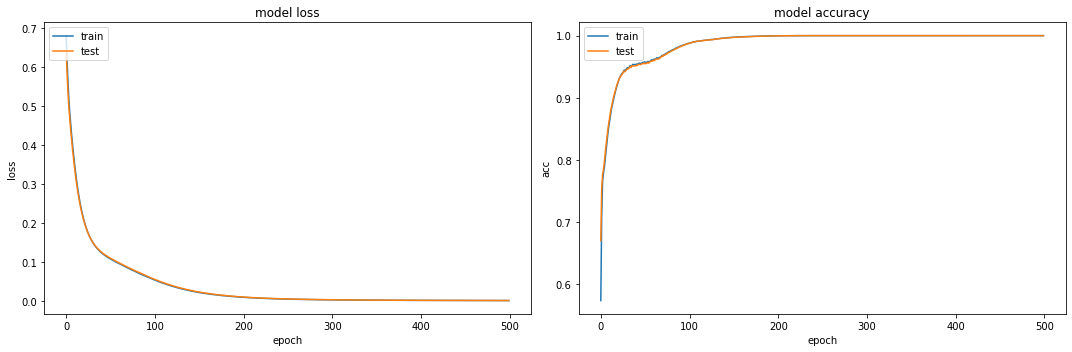

In [8]:
# summarize history for loss and acc
show_acc_loss_curves(dyn_history)

In [9]:
test_model(dyn_model, test_data)

1517/1517 [==============================] - 0s 59us/sample - loss: 4.3914e-04 - acc: 1.0000


The results show that the network is able to quickly extract the relevant dynamics from the input data, represented by the steep decline of the loss curve after only a few epochs.

### II.II. Transfer Learning
In order to better learn the reward based on an action in a specific situation, we use the trained model from the previous task and attach 2 more layers on top of it. This is meant to use the knowledge gained about game dynamics for predicting the probability of winning after a given action.  
Since we were not completely sure which combination of activation and loss functions was best suited to this purpose, we created a grid search over the following parameters:  
- ***activation of last layer***: sigmoid or linear
- ***loss function***: cross-entropy/logloss, mean squared error/Brier score for logistic activation
- ***optimiser***: Nesterov Momentum (NAG), Adaptive Moment Estimation (ADAM)
- ***learning rate***: 0.0001, ...
- ***batch size***: 10, 20, 40, 60, 80, 100, 200, 500, 1000

In [10]:
import numpy as np
import keras.backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# define custom log loss
def log_loss(y_true, y_pred):
    print(y_true)
    return K.mean(-K.log(abs(y_true - y_pred)))

# define custom mean absolute error metric
def mea_metric(y_true, y_pred):
    return K.mean(abs(y_true - y_pred))

def copy_model(model, loss, optimiser):
    model_copy= clone_model(model)
    
    if optimiser == "nag":
        opt = SGD(learning_rate=learning_rate, nesterov=True)
    elif optimiser == "adam":
        opt = Adam(learning_rate=learning_rate)
        
    model_copy.compile(loss=loss, optimizer=opt, metrics=["acc", mea_metric])
    model_copy.set_weights(model.get_weights())
    return model_copy

# Function to create model, required for KerasClassifier
def create_model(last_activation, loss_funct, optimiser, learning_rate, base_model = dyn_model, transfer_learning = True):
    # remove output layer of base model
    model = copy_model(base_model, loss_funct, optimiser)
    model.pop()
    # transfer learning condition
    if transfer_learning:
        model.layers[0].trainable = False
    # additional layers for learning
    start = Dense(120, activation='relu')(model.layers[-1].output)
    end = Dense(250, activation='relu')(start)
    out_r = Dense(1, activation=last_activation, name='r_prop')(end)
    final_model = Model(model.input,out_r)
    # Compile model
    if optimiser == "nag":
        opt = SGD(learning_rate=learning_rate, nesterov=True)
    elif optimiser == "adam":
        opt = Adam(learning_rate=learning_rate)

    final_model.compile(loss=loss_funct, optimizer=opt, metrics=["acc", mea_metric])
    return final_model

# set hyperparameter search space
last_activation = ["sigmoid", "linear"]
loss_funct = ["mse", log_loss]
optimiser = ["nag", "adam"]
learning_rate = [0.0001, 0.0005] #, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
batch_size = [10, 20] #, 40, 60, 80, 100, 200, 500, 1000]
epochs = [10]

param_grid = dict(last_activation = last_activation, loss_funct = loss_funct, optimiser = optimiser,
                  learning_rate = learning_rate, batch_size = batch_size, epochs = epochs)



Using TensorFlow backend.


In [12]:
# seed = 7
# np.random.seed(seed)


# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(train_data["input"], train_data["pred"])

Tensor("dense_1_target_7:0", shape=(None, None), dtype=float32)
Tensor("r_prop_target_6:0", shape=(None, None), dtype=float32)
Tensor("dense_1_target_8:0", shape=(None, None), dtype=float32)
Tensor("r_prop_target_7:0", shape=(None, None), dtype=float32)
Tensor("dense_1_target_9:0", shape=(None, None), dtype=float32)
Tensor("r_prop_target_8:0", shape=(None, None), dtype=float32)
Tensor("dense_1_target_10:0", shape=(None, None), dtype=float32)
Tensor("r_prop_target_9:0", shape=(None, None), dtype=float32)
Tensor("dense_1_target_11:0", shape=(None, None), dtype=float32)
Tensor("r_prop_target_10:0", shape=(None, None), dtype=float32)
Tensor("dense_1_target_12:0", shape=(None, None), dtype=float32)
Tensor("r_prop_target_11:0", shape=(None, None), dtype=float32)
Tensor("dense_1_target_19:0", shape=(None, None), dtype=float32)
Tensor("r_prop_target_18:0", shape=(None, None), dtype=float32)
Tensor("dense_1_target_20:0", shape=(None, None), dtype=float32)
Tensor("r_prop_target_19:0", shape=(Non

In [13]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.001813 using {'batch_size': 10, 'epochs': 10, 'last_activation': 'linear', 'learning_rate': 0.0001, 'loss_funct': 'mse', 'optimiser': 'nag'}
0.000165 (0.000233) with: {'batch_size': 10, 'epochs': 10, 'last_activation': 'sigmoid', 'learning_rate': 0.0001, 'loss_funct': 'mse', 'optimiser': 'nag'}
0.000165 (0.000233) with: {'batch_size': 10, 'epochs': 10, 'last_activation': 'sigmoid', 'learning_rate': 0.0001, 'loss_funct': 'mse', 'optimiser': 'adam'}
0.000659 (0.000617) with: {'batch_size': 10, 'epochs': 10, 'last_activation': 'sigmoid', 'learning_rate': 0.0001, 'loss_funct': <function log_loss at 0x7f4e7c50f8c0>, 'optimiser': 'nag'}
0.001154 (0.000840) with: {'batch_size': 10, 'epochs': 10, 'last_activation': 'sigmoid', 'learning_rate': 0.0001, 'loss_funct': <function log_loss at 0x7f4e7c50f8c0>, 'optimiser': 'adam'}
0.000165 (0.000233) with: {'batch_size': 10, 'epochs': 10, 'last_activation': 'sigmoid', 'learning_rate': 0.0005, 'loss_funct': 'mse', 'optimiser': 'nag'}
0.000165 (